In [4]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [11]:
DATASET_PATH = 'Dataset (copy)/'

data_dir = pathlib.Path(DATASET_PATH)

The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [12]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['emabega' 'ddyo' 'gaali' 'kkono' 'mu masso' 'yimirira']


Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`.

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [13]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 1435 files belonging to 6 classes.
Using 1148 files for training.
Using 287 files for validation.

label names: ['ddyo' 'emabega' 'gaali' 'kkono' 'mu masso' 'yimirira']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [14]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [15]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The utils.audio_dataset_from_directory function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use Dataset.shard to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction.

In [16]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [17]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

2024-01-23 12:23:42.433859: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Bad bytes per sample in WAV header: Expected 2 but got 4
2024-01-23 12:23:42.434012: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Bad bytes per sample in WAV header: Expected 2 but got 4
2024-01-23 12:23:42.434182: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Bad bytes per sample in WAV header: Expected 2 but got 4
2024-01-23 12:23:42.434264: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Bad bytes per sample in WAV header: Expected 2 but got 4
2024-01-23 12:23:42.434692: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Bad bytes per sample in WAV header: Expected 2 but got 4
2024-01-23 12:23:42.434891: W 

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Bad bytes per sample in WAV header: Expected 2 but got 4
	 [[{{node DecodeWav}}]] [Op:IteratorGetNext] name: 

Let's plot a few audio waveforms:

In [13]:
label_names[[1,1,3,0]]

array(['emabega', 'emabega', 'kkono', 'ddyo'], dtype='<U8')

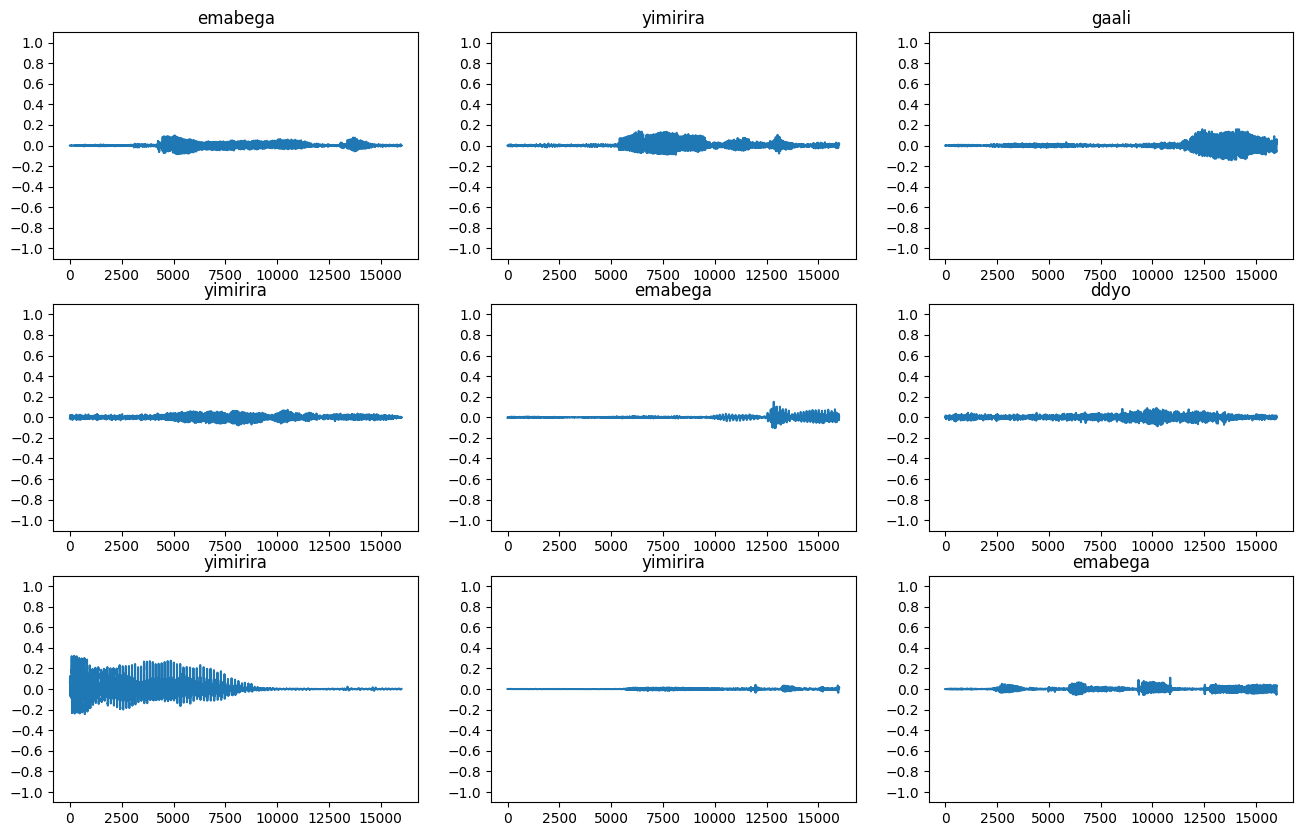

In [14]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [15]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [16]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: emabega
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: yimirira
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: gaali
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [15]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

NameError: name 'waveform' is not defined

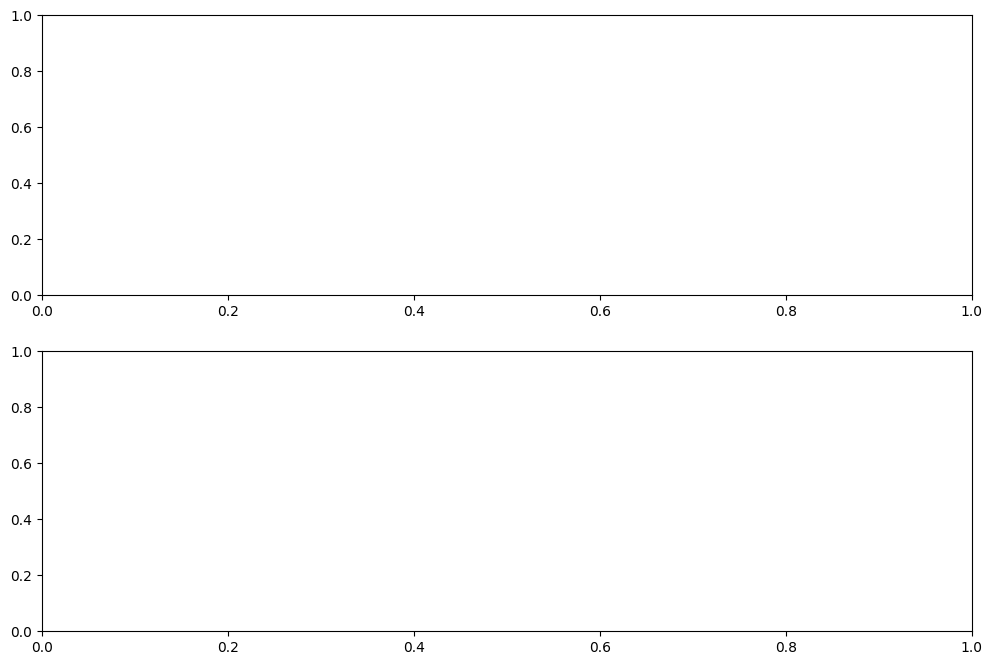

In [16]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogram datasets from the audio datasets:

In [17]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [18]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [19]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

2024-01-14 15:19:58.946036: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Bad bytes per sample in WAV header: Expected 2 but got 4
2024-01-14 15:19:58.946289: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Bad bytes per sample in WAV header: Expected 2 but got 4
2024-01-14 15:19:58.946367: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Bad bytes per sample in WAV header: Expected 2 but got 4
2024-01-14 15:19:58.946557: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Bad bytes per sample in WAV header: Expected 2 but got 4
2024-01-14 15:19:58.946678: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Bad bytes per sample in WAV header: Expected 2 but got 4
2024-01-14 15:19:58.946758: W 

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Bad bytes per sample in WAV header: Expected 2 but got 4
	 [[{{node DecodeWav}}]] [Op:IteratorGetNext] name: 

NameError: name 'example_spectrograms' is not defined

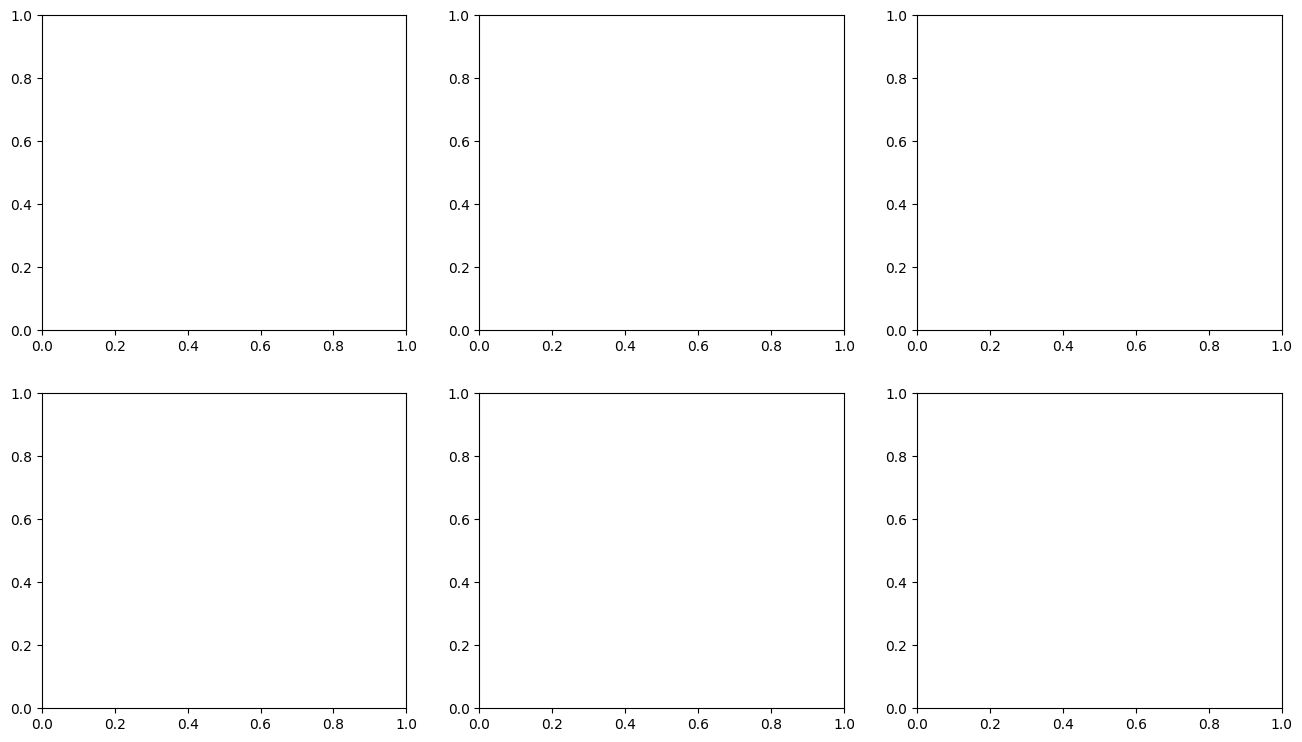

In [20]:
rows = 2
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [21]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [22]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

NameError: name 'example_spectrograms' is not defined

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over 10 epochs for demonstration purposes:

In [28]:
EPOCHS = 15
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/15
75/75 [==============================] - 17s 193ms/step - loss: 1.3776 - accuracy: 0.4848 - val_loss: 0.8617 - val_accuracy: 0.7552
Epoch 2/15
75/75 [==============================] - 13s 178ms/step - loss: 0.8389 - accuracy: 0.7196 - val_loss: 0.5528 - val_accuracy: 0.8472
Epoch 3/15
75/75 [==============================] - 13s 177ms/step - loss: 0.5932 - accuracy: 0.8067 - val_loss: 0.4374 - val_accuracy: 0.8715
Epoch 4/15
75/75 [==============================] - 13s 178ms/step - loss: 0.4547 - accuracy: 0.8504 - val_loss: 0.3408 - val_accuracy: 0.8958
Epoch 5/15
75/75 [==============================] - 13s 171ms/step - loss: 0.3644 - accuracy: 0.8838 - val_loss: 0.3116 - val_accuracy: 0.9062
Epoch 6/15
75/75 [==============================] - 12s 155ms/step - loss: 0.3109 - accuracy: 0.9006 - val_loss: 0.2890 - val_accuracy: 0.9201
Epoch 7/15
75/75 [==============================] - 11s 148ms/step - loss: 0.2611 - accuracy: 0.9127 - val_loss: 0.2695 - val_accuracy: 0.9288

Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

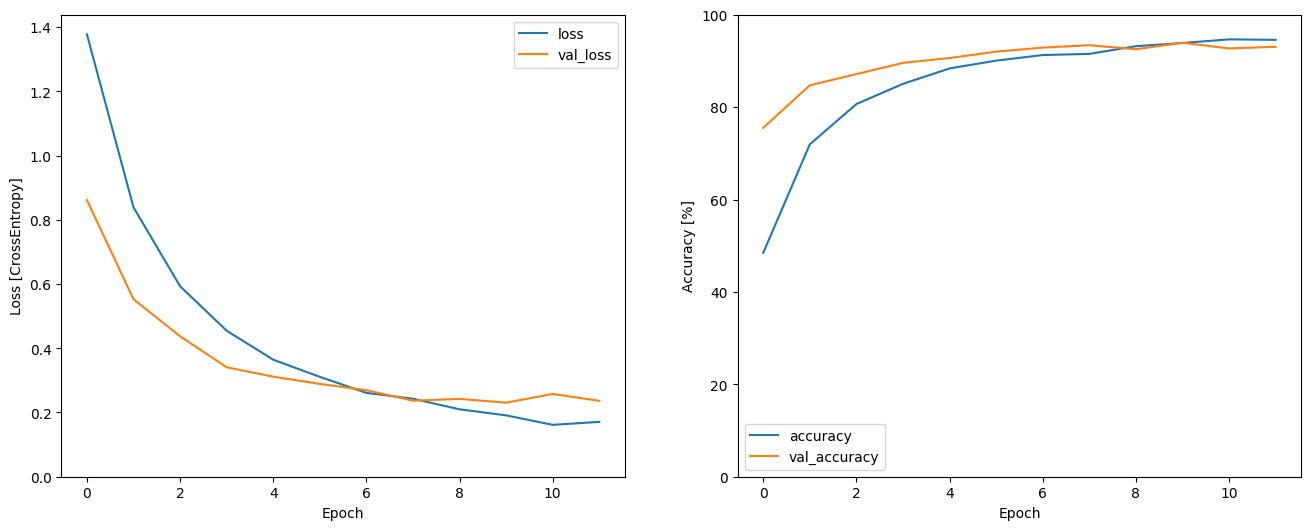

In [29]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [30]:
model.evaluate(test_spectrogram_ds, return_dict=True)

10/10 [==============================] - 1s 71ms/step - loss: 0.2761 - accuracy: 0.9119


{'loss': 0.2761494219303131, 'accuracy': 0.9118589758872986}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [31]:
y_pred = model.predict(test_spectrogram_ds)

10/10 [==============================] - 1s 39ms/step


In [32]:
y_pred = tf.argmax(y_pred, axis=1)

In [33]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

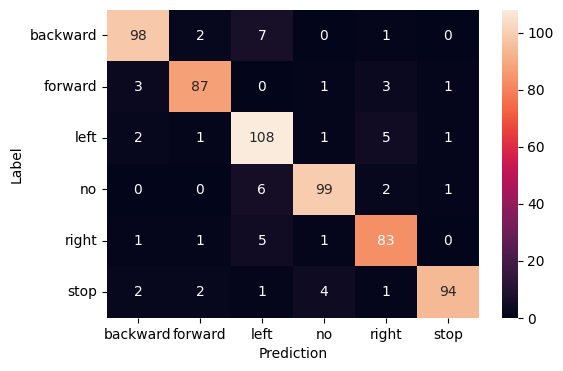

In [36]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

In [39]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

x_labels = ['backward','forward', 'left', 'no', 'right', 'stop']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

InvalidArgumentError: Value for attr 'T' of int64 is not in the list of allowed values: half, bfloat16, float, double
	; NodeDef: {{node Softmax}}; Op<name=Softmax; signature=logits:T -> softmax:T; attr=T:type,allowed=[DT_HALF, DT_BFLOAT16, DT_FLOAT, DT_DOUBLE]> [Op:Softmax] name: 

As the output suggests, your model should have recognized the audio command as "no".

## Export the model with preprocessing

The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [ ]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Test run the "export" model:

In [ ]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[-1.3277637 ,  1.0930616 , -2.2258034 ,  2.806897  , -2.3685236 ,
         -0.19146055]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

Save and reload the model, the reloaded model gives identical output:

In [ ]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

{'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>,
 'predictions': <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[-1.3277637 ,  1.0930616 , -2.2258034 ,  2.806897  , -2.3685236 ,
         -0.19146055]], dtype=float32)>}